# Interactive time series retrieval

This notebook describes how to interactively select a time series of surface reflectance for single band

In [1]:
%pylab notebook
from __future__ import print_function
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
from IPython.display import display
import ipywidgets as widgets

Populating the interactive namespace from numpy and matplotlib


In [2]:
dc = datacube.Datacube(app='Interactive time series analysis')

In [3]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords


#Define temporal range
start_of_epoch = '2013-01-01'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     #'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensors = ['ls8']#, 'ls7', 'ls5'] 

query = {'time': (start_of_epoch, end_of_epoch)}
lat_max = -17.42
lat_min = -17.45
lon_max = 140.90522
lon_min = 140.8785

query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [4]:
print(query)

{'time': ('2013-01-01', '2016-12-31'), 'y': (-17.42, -17.45), 'crs': 'EPSG:4326', 'x': (140.8785, 140.90522)}


## retrieve the NBAR and PQ for the spatiotemporal range of interest


In [5]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [6]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', **query)
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #This line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    #Apply the PQ masks to the NBAR
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)
    sensor_clean[sensor] = sensor_nbar

## Plotting an image select a location to retrieve a time series

In [7]:
#select time slice of interest - this is trial and error until you get a decent image
time_slice_i = 140
rgb = sensor_clean['ls8'].isel(time =time_slice_i).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
#rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20170327/envs/agdc/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


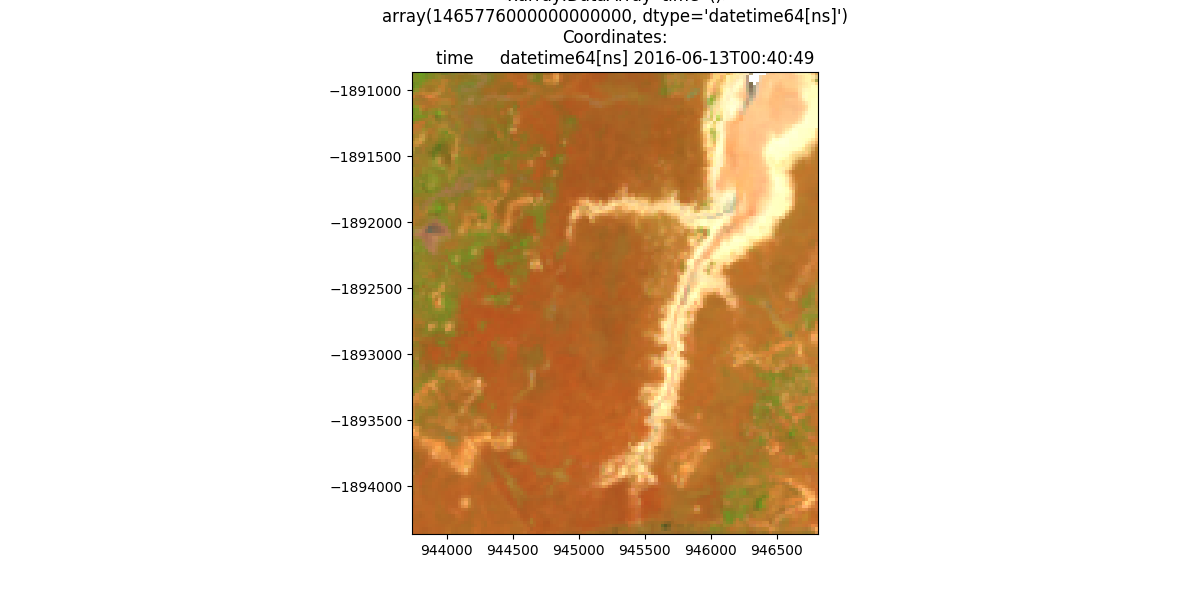

In [8]:
#Click on this image to chose the location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
#plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r') #turn this on or off to show location of transect
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

fig.canvas.mpl_connect('button_press_event', callback)
date_ = sensor_clean['ls8'].time[time_slice_i]
plt.title(date_.astype('datetime64[D]'))
plt.show()
display(w)

In [9]:
#this converts the map x coordinate into image x coordinates
image_coords = ~sensor_clean['ls8'].affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

In [10]:
green_ls8 = sensor_clean['ls8'].green.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')

<IPython.core.display.Javascript object>


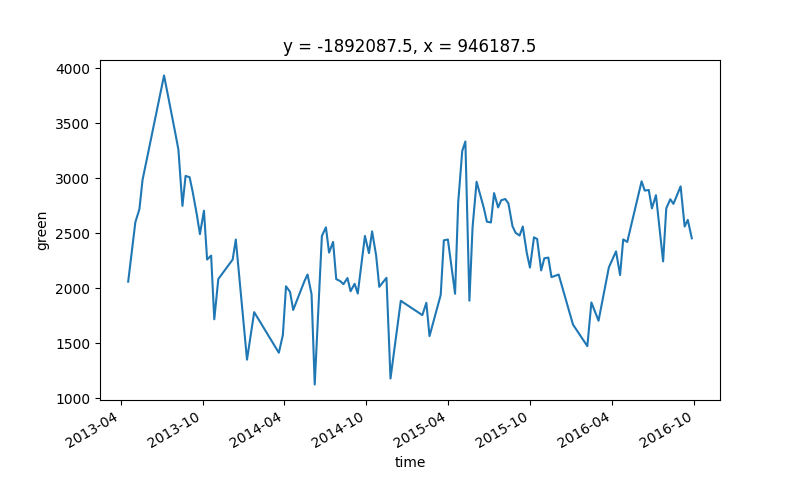

In [11]:
#plot a time series of green reflectance for the location that you clicked
fig = plt.figure(figsize=(8,5))
green_ls8.plot()